In [27]:
#import pandas as pd
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt
import pickle

#from tslearn.utils import to_time_series_dataset
#from tslearn.clustering import TimeSeriesKMeans

from sktime.clustering.k_means import TimeSeriesKMeans

import warnings
warnings.filterwarnings('ignore')

fase = '02b_DTW'

In [28]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [29]:
folder = gen_config['folder']

#entradas
path_norm = gen_config['path_norm']
path_prod_stats = gen_config['path_prod_stats']
path_overall_prod_stats = gen_config['path_overall_prod_stats']
#salidas
path_dtw = gen_config['path_dtw']
path_traindtw = gen_config['path_traindtw']
path_fitdtw = gen_config['path_fitdtw']
#variables
clusters = gen_config['var_clusters']
path_dtwmodel = gen_config['path_dtw_model']
leer_pickle_dtw = gen_config['var_leer_pickle_dtw']
ejecutar_dtw = gen_config['var_ejecutar_dtw']


print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------


In [30]:
df_norm = pl.read_parquet(f"{folder}/{path_norm}")
prod_stats = pl.read_parquet(f'{folder}/{path_prod_stats}')
overall_prod_stats = pl.read_parquet(f'{folder}/{path_overall_prod_stats}')

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")

df_norm shape:   (5_303_555,20)


In [31]:
df_norm = df_norm.with_columns([
    ((pl.col("periodo").cast(pl.Utf8) + "01").str.to_date("%Y%m%d")).alias("periodo_dt"),  
])

In [32]:
primer_periodo = df_norm['periodo_dt'].min()
df_norm['periodo','periodo_dt']

df_norm = df_norm.with_columns(
    ((pl.col('periodo_dt').dt.year() - primer_periodo.year) * 12 +
    (pl.col('periodo_dt').dt.month() - primer_periodo.month)).alias('mes_indice')
)

In [33]:
fijos = 150
sample = 150

productos_fijos = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[:fijos][:,0]
productos_sample = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[fijos:][:,0].sample(sample, seed=42)
productos_otros = overall_prod_stats['product_id'].filter(~overall_prod_stats['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))

In [34]:
df_norm = df_norm.sort(by=['product_id', 'customer_id', 'periodo'])

df_train = df_norm.filter(df_norm['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))
df_fit = df_norm.filter(df_norm['product_id'].is_in(productos_otros))

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")
print(f"df_train shape:  ({df_train.shape[0]:>9_d},{df_train.shape[1]:_d})")
print(f"df_fit shape:    ({df_fit.shape[0]:>9_d},{df_fit.shape[1]:_d})")

df_norm shape:   (5_303_555,20)
df_train shape:  (2_495_807,20)
df_fit shape:    (2_807_748,20)


In [35]:
prod_stats = prod_stats.to_pandas()
df_train = df_train.to_pandas()
df_fit = df_fit.to_pandas()

In [36]:
prodcust_train = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
prodcust_fit = df_fit[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
meses = pd.DataFrame({'mes_indice': df_train['mes_indice'].unique()})

print(f"prodcust_train series:  ({prodcust_train.shape[0]:>9_d},{df_train.shape[1]:_d}, productos unicos: {df_train['product_id'].nunique()})")
print(f"prodcust_fit series:    ({prodcust_fit.shape[0]:>9_d},{df_fit.shape[1]:_d}, productos unicos: {df_fit['product_id'].nunique()})")

prodcust_train series:  (   77_636,20, productos unicos: 300)
prodcust_fit series:    (  101_048,20, productos unicos: 480)


In [37]:
X_train = prodcust_train.merge(meses, how='cross')
X_train = X_train.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_train['prodcust'] = X_train['product_id'].astype(str) + '_' + X_train['customer_id'].astype(str)
X_train = X_train.drop(columns=['product_id', 'customer_id'])
X_train.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_train: {X_train['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_train['tn_norm'] = X_train['tn_norm'].fillna(0)
print(f"X_train series:    ({X_train.shape[0]:>9_d},{X_train.shape[1]:_d})")

Nulos en X_train: 299089. Se reemplazan por ceros
X_train series:    (2_794_896,1)


In [38]:
X_fit = prodcust_fit.merge(meses, how='cross')
X_fit = X_fit.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_fit['prodcust'] = X_fit['product_id'].astype(str) + '_' + X_fit['customer_id'].astype(str)
X_fit = X_fit.drop(columns=['product_id', 'customer_id'])
X_fit.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_fit: {X_fit['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_fit['tn_norm'] = X_fit['tn_norm'].fillna(0)
print(f"X_fit series:    ({X_fit.shape[0]:>9_d},{X_fit.shape[1]:_d})")

Nulos en X_fit: 3637728. Se reemplazan por ceros
X_fit series:    (3_637_728,1)


In [39]:
start_time = datetime.now()

model = TimeSeriesKMeans(n_clusters=clusters[0],
                        metric="dtw",
                        init_algorithm = 'forgy',
                        n_init=1, max_iter=10, tol=10,
                        verbose = True,
                        averaging_method='mean',
                        random_state=42
                        )
x_clusters_dtw = model.fit_predict(X_train)
print(f"FINALIZADO! clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")

Iteration 0, inertia 1052165311693.1085.
Iteration 1, inertia 993429679178.9562.
Iteration 2, inertia 909476768467.2169.
Iteration 3, inertia 842221252794.1222.
Iteration 4, inertia 779338060152.4277.
Iteration 5, inertia 708062315765.2008.
Iteration 6, inertia 604320555766.7753.
Iteration 7, inertia 552439357215.9729.
Iteration 8, inertia 539802281126.6964.
Iteration 9, inertia 531772762523.675.
FINALIZADO! clusters: 15, inertia: 522241902784.69, time: 46.27


In [40]:
model.save(f"{folder}/{path_dtwmodel}", serialization_format='pickle')

<zipfile.ZipFile filename='Experimentos\\2024-07-09_Candidato\\02b_dtw_model.zip' mode='r'>

In [41]:
x_clusters_dtw_fit = model.predict(X_fit)

In [42]:
#from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
#plot_cluster_algorithm(model, X_fit[:100], model.n_clusters)

In [43]:
df_clusters = pd.concat([prodcust_train.reset_index(drop=True), pd.DataFrame(x_clusters_dtw)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters.columns = cols

In [44]:
df_clusters_fit = pd.concat([prodcust_fit.reset_index(drop=True), pd.DataFrame(x_clusters_dtw_fit)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters_fit.columns = cols

In [45]:
df_clusters_full = pd.concat([df_clusters, df_clusters_fit], axis=0)
df_clusters_full.to_parquet(f"{folder}/{path_dtw}", index=False)

print(f"df_clusters_full series:  ({df_clusters_full.shape[0]:>9_d},{df_clusters_full.shape[1]:_d}, productos unicos: {df_clusters_full['product_id'].nunique()})")

df_clusters_full series:  (  178_684,3, productos unicos: 780)


In [46]:
report = df_clusters_full.groupby(f'cluster_dtw_{clusters[0]:0>2}').agg(['count', 'nunique'])

print('Clusters de DTW: Reporte')
print(report)

Clusters de DTW: Reporte
               product_id         customer_id        
                    count nunique       count nunique
cluster_dtw_15                                       
0                   13031     300       13031     455
1                     407      53         407     211
2                   11702     284       11702     471
3                    7583     259        7583     312
4                    4743     273        4743     440
5                    4699     291        4699     472
6                    4860     293        4860     316
7                    2298     269        2298     407
8                     192      29         192     129
9                      97      21          97      78
10                 114275     780      114275     523
11                     10      10          10       9
12                   1232     284        1232     368
13                   8071     233        8071     467
14                   5484     230        5484     462


In [47]:
dibu = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
dibu['cluster'] = x_clusters_dtw
dibu = dibu.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id'], how='left')
dibu = dibu.pivot(index=['product_id','customer_id','cluster'], columns='mes_indice', values='tn_norm').reset_index()

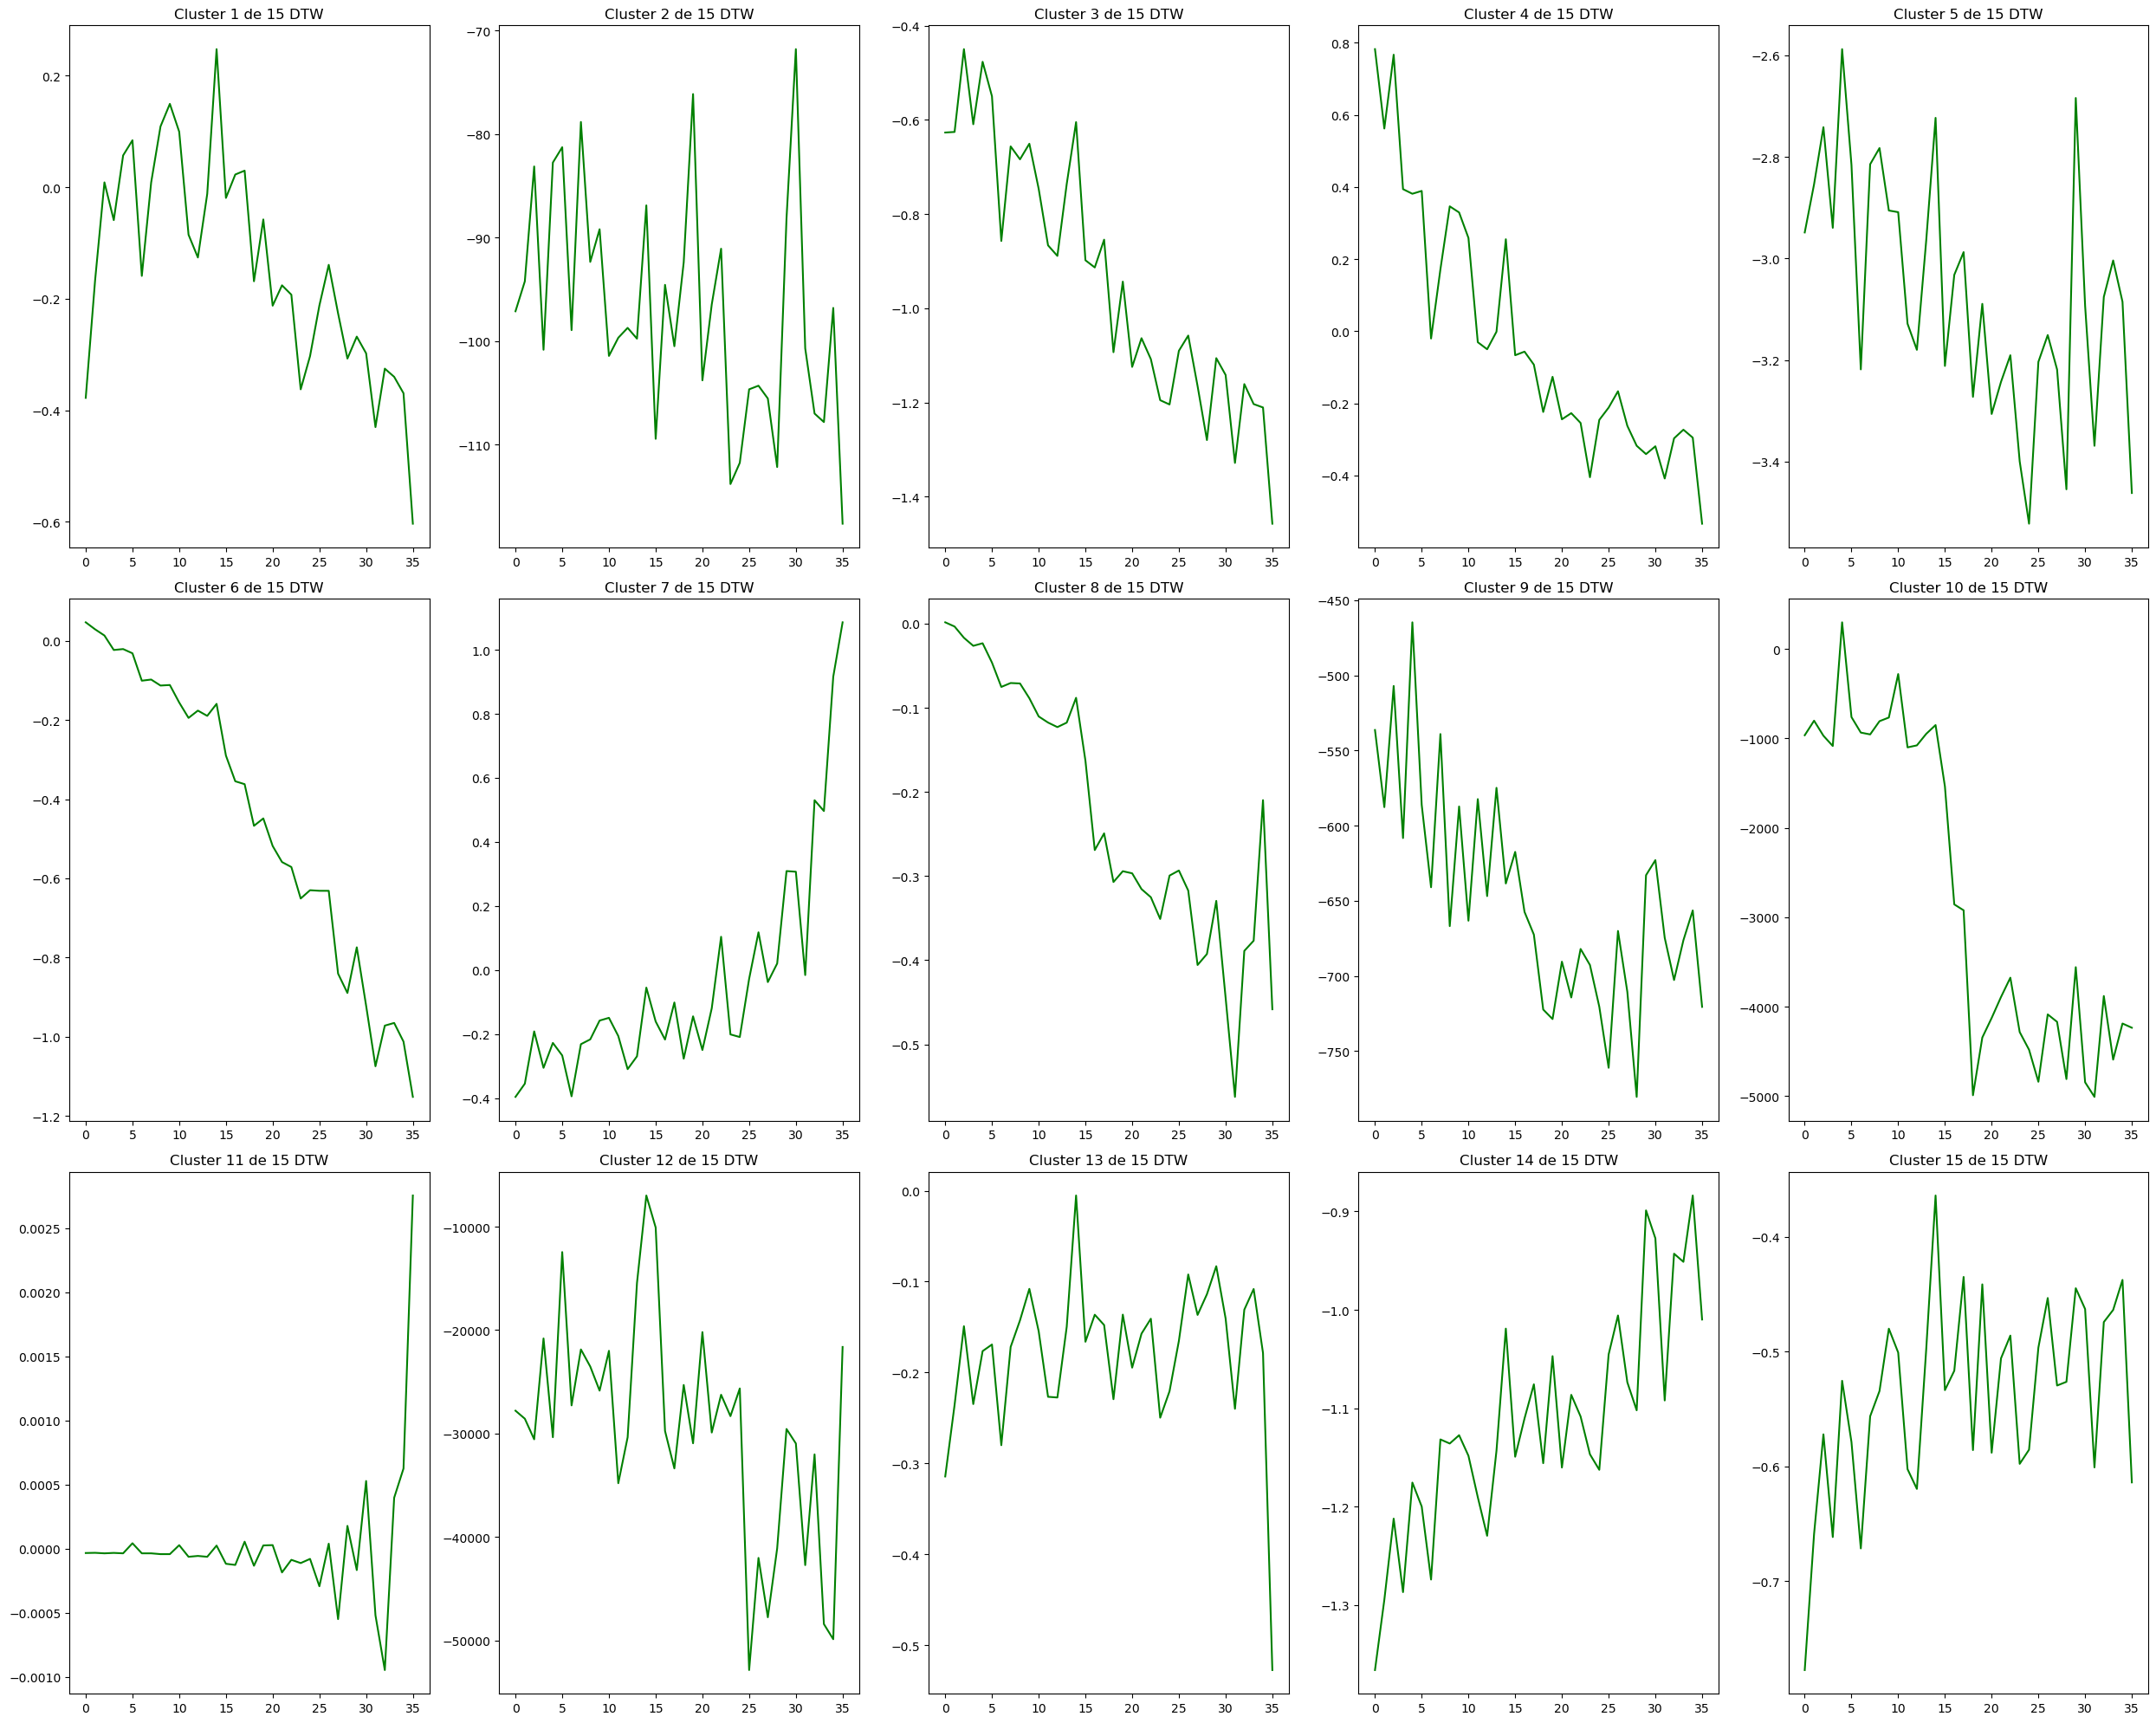

In [56]:
sample = 100
dibu_sample = pd.DataFrame()
fig, axs = plt.subplots(3, 5, figsize=(25, 20))

y_pred = x_clusters_dtw

for j in range(clusters[0]):
    axs[j//5, j%5].plot(model.cluster_centers_[j].ravel(), color='green')
    axs[j//5, j%5].set_title(f"Cluster {j+1} de {clusters[0]} DTW")
    try:
        dibu_sample = dibu[dibu['cluster']==j].sample(min(dibu_sample.shape[0],sample), random_state=42)
    except:
        continue
    
    for s in range(min(dibu_sample.shape[0],sample)):
        axs[j//5, j%5].plot(dibu_sample.iloc[s,3:].values, color='blue', alpha=0.5)

plt.tight_layout()

plt.show()

In [ ]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



